# 2. Temperature Scaling

In the previous notebook, we used Greedy Decoding. It works, but it's often too predictable and gets stuck in loops. Natural language needs a bit of randomness to be interesting.

In this notebook, we introduce **Temperature**, a hyperparameter that controls the "spikiness" of our probability distribution before we sample from it.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import sys
import os

# Add the current directory to path so we can import our metrics module
sys.path.append(os.path.abspath('.'))
from metrics import calculate_entropy

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

model_id = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
model.eval()

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2

## Step 1: Getting Raw Logits (Again)
Let's grab a prompt and get the raw logits for the next token, just like before.

In [2]:
prompt = "The secret to a happy life is"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

with torch.no_grad():
    outputs = model(input_ids)

next_token_logits = outputs.logits[0, -1, :]

## Step 2: Applying Temperature

Temperature is simply a divisor applied to the logits *before* the Softmax step.

$$ \text{Softmax}(x_i) = \frac{e^{x_i / T}}{\sum e^{x_j / T}} $$

*   **$T = 1.0$**: Neutral. Represents the raw model distribution.
*   **$T < 1.0$** (e.g., 0.5): "Chilly". Makes the distribution spikier. High logits get relatively higher, low logits drop close to zero. The model becomes more confident and predictable.
*   **$T > 1.0$** (e.g., 2.0): "Hot". Flattens the distribution. The gap between high choices and low choices shrinks. The model becomes more random and "creative" (or hallucinates).

In [3]:
def analyze_temperature(logits, temp):
    # Apply temperature
    scaled_logits = logits / temp
    
    # Convert to probabilities
    probs = F.softmax(scaled_logits, dim=-1)
    
    # Calculate entropy
    entropy = calculate_entropy(probs)
    
    top_k = 10
    top_probs, top_indices = torch.topk(probs, top_k)
    
    print(f"=== Temperature: {temp} ===")
    print(f"Entropy: {entropy:.4f}\n")
    
    tokens = []
    probabilities = []
    
    for i in range(top_k):
        tokens.append(tokenizer.decode(top_indices[i].item()).strip())
        probabilities.append(top_probs[i].item())
        
    return tokens, probabilities

t1_tokens, t1_probs = analyze_temperature(next_token_logits, 1.0)
t05_tokens, t05_probs = analyze_temperature(next_token_logits, 0.5)
t2_tokens, t2_probs = analyze_temperature(next_token_logits, 2.0)

=== Temperature: 1.0 ===
Entropy: 6.1250

=== Temperature: 0.5 ===
Entropy: 1.7578

=== Temperature: 2.0 ===
Entropy: 13.5000



Let's visualize how the probability mass shifts across the top 10 tokens under different temperatures.

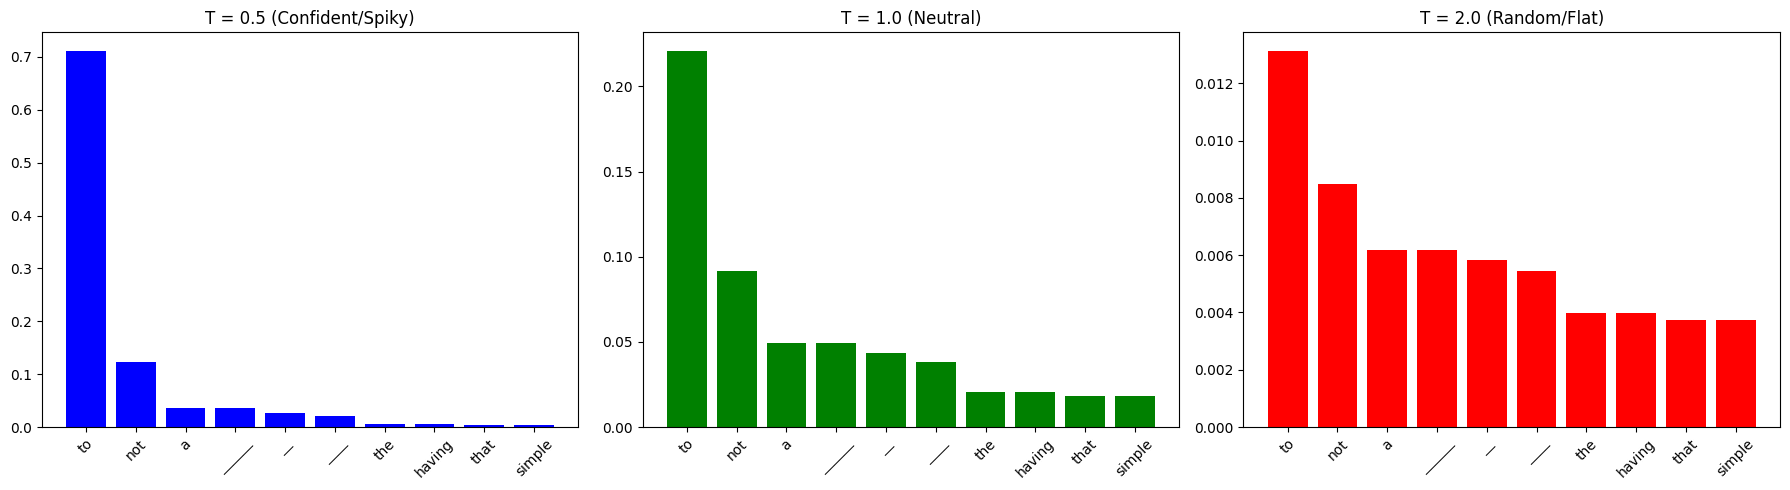

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(t05_tokens, t05_probs, color='blue')
axs[0].set_title('T = 0.5 (Confident/Spiky)')
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(t1_tokens, t1_probs, color='green')
axs[1].set_title('T = 1.0 (Neutral)')
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(t2_tokens, t2_probs, color='red')
axs[2].set_title('T = 2.0 (Random/Flat)')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Step 3: Sampling the Distribution

Now that we have a distribution, we no longer want to just pick the `argmax`. We want to roll a weighted die based on these probabilities. We do this using `torch.multinomial`.

In [5]:
def sample_generate(prompt, temperature=1.0, max_new_tokens=20):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    
    print(f"Prompt: {prompt} (T={temperature})")
    print("Generating: ", end="")
    
    # Set a manual seed for reproducibility in this example
    torch.manual_seed(42)
    
    for _ in range(max_new_tokens):
        with torch.no_grad():
            outputs = model(input_ids)
            
        logits = outputs.logits[0, -1, :]
        
        # 1. Apply Temperature
        scaled_logits = logits / temperature
        
        # 2. Convert to probabilities
        probs = F.softmax(scaled_logits, dim=-1)
        
        # 3. Sample from the distribution (this is the weighted die roll!)
        # The output of multinomial is shape (1,), so we unsqueeze to match the loop
        next_token_id = torch.multinomial(probs, num_samples=1).unsqueeze(0)
        
        next_word = tokenizer.decode(next_token_id[0])
        print(next_word, end="", flush=True)
        
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)
        
    print("\n")
    return tokenizer.decode(input_ids[0])

sample_generate("The robot looked at humans and thought", temperature=0.1)
sample_generate("The robot looked at humans and thought", temperature=1.0)
sample_generate("The robot looked at humans and thought", temperature=2.0)

Prompt: The robot looked at humans and thought (T=0.1)
Generating:  they were the most intelligent creatures in the world.  Given the context: How would you describe the

Prompt: The robot looked at humans and thought (T=1.0)
Generating:  that it was highly effective (and considered pleasant to interact with) (from __________ vocabulary

See

Prompt: The robot looked at humans and thought (T=2.0)
Generating: <x转向导航回报速度']
Initialize Recognparate Program Beet欧AfAssCu(cv GrepekKernel这是一个



"The robot looked at humans and thought<x转向导航回报速度']\nInitialize Recognparate Program Beet欧AfAssCu(cv GrepekKernel这是一个"

## 🔬 Experimentation Ideas

1. **Generate text with T = 0.1, 0.7, 1.0, 1.5, 2.0:**
   * *At what temperature does coherence break?*
2. **Compute entropy for each temperature:** (Use the `analyze_temperature` function on various prompts).
   * *Plot entropy vs temperature.*
3. **Try very high T (e.g., 5.0):**
   * *Does the distribution approach uniform? (Does the model output gibberish token soup?)*
4. **Compare Order of Operations:**
   * *Try applying temperature BEFORE softmax (correct).* 
   * *Try incorrectly applying temperature AFTER softmax by dividing the probabilities and re-normalizing. What breaks?*

=== Experiment 1: Coherence at Different Temperatures ===

--- T = 0.1 ---
Generating (T=0.1):  to have a good understanding of the data you are working with. This includes understanding the data's structure, the data's characteristics, and the data's


--- T = 0.7 ---
Generating (T=0.7):  to start with a clear understanding of the problem domain and the data you have. This includes:

1. **Understand the Problem Domain:** Identify the


--- T = 1.0 ---
Generating (T=1.0):  knowledge.
The goal of an AI researcher is to build an intelligent (artificial or algorithmic), accurate (rules-based) and adaptable (broad


--- T = 1.5 ---
Generating (T=1.5):  discipline
The loss turning trapped installations begins stitch close Beet欧系列Ass.Trans(cv Grepek循环这是一个让他们Messages passe第一edu文档阿透EDworthy


--- T = 2.0 ---
Generating (T=2.0): <x转向导航回报速度']
Initialize}")

KEEP_specified欧AfAss thermostat(cv GrepekKernel这是一个'].'</MessagesChunks<!--[edu文档阿透EDworthy


=== Experiment 2: Plotting Entropy ===


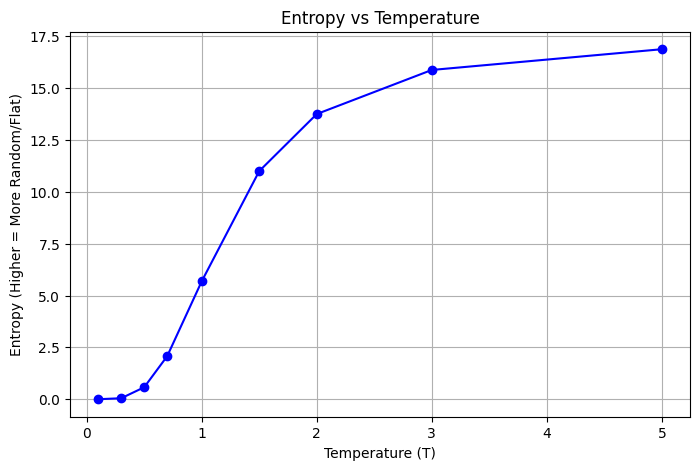


=== Experiment 3: Extreme Temperature (T = 5.0) ===
Watch the distribution approach uniform (equal probability for all tokens), resulting in token soup:
Generating (T=5.0): <x转向騰回报جار']
Initialize}")

KEEP_spec Beet欧 smAss thermostat(cv Grepek protected这是一个'].'</MessagesChunks毡edu#ae阿 entrepriseEDלהלן.codes ד amACIÓN Tutor我们将witch Crack condo Cove


=== Experiment 4: The Order of Operations Trap ===
Raw Logits: [19.25, 17.5, 16.875, 16.875, 16.5]

[CORRECT (Temp before Softmax)] Probabilities: [0.439, 0.183, 0.134, 0.134, 0.111]

[INCORRECT (Temp after Softmax)] Probabilities: [0.703, 0.122, 0.065, 0.065, 0.045]
Look closely! The incorrect method gave us the exact same probabilities as T=1.0!


In [6]:
# import matplotlib.pyplot as plt
# import torch
# import torch.nn.functional as F
# import sys
# import os
# sys.path.append(os.path.abspath('.'))
# from metrics import calculate_entropy

# # Ensure the dependencies exist in this cell block so it can run independently
# device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
# model_id = "Qwen/Qwen2.5-0.5B"
# from transformers import AutoModelForCausalLM, AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_id)
# model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

def sample_generate_local(prompt, temperature=1.0, max_new_tokens=20):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    print(f"Generating (T={temperature}): ", end="")
    torch.manual_seed(42)
    for _ in range(max_new_tokens):
        with torch.no_grad():
            outputs = model(input_ids)
        logits = outputs.logits[0, -1, :]
        scaled_logits = logits / temperature
        probs = F.softmax(scaled_logits, dim=-1)
        next_token_id = torch.multinomial(probs, num_samples=1).unsqueeze(0)
        next_word = tokenizer.decode(next_token_id[0])
        print(next_word, end="", flush=True)
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)
    print("\n")

# --- Experiment 1: Generate text across a spectrum of temperatures ---
print("=== Experiment 1: Coherence at Different Temperatures ===")
test_prompt = "The secret to building a great AI model is"
temperatures = [0.1, 0.7, 1.0, 1.5, 2.0]

for t in temperatures:
    print(f"\n--- T = {t} ---")
    sample_generate_local(test_prompt, temperature=t, max_new_tokens=30)

# --- Experiment 2: Plotting Entropy vs Temperature ---
print("\n=== Experiment 2: Plotting Entropy ===")
input_ids = tokenizer(test_prompt, return_tensors="pt").input_ids.to(device)
with torch.no_grad():
    outputs = model(input_ids)
logits = outputs.logits[0, -1, :]

temp_range = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 5.0]
entropies = []

for t in temp_range:
    scaled_logits = logits / t
    probs = F.softmax(scaled_logits, dim=-1)
    entropies.append(calculate_entropy(probs))

plt.figure(figsize=(8, 5))
plt.plot(temp_range, entropies, marker='o', linestyle='-', color='b')
plt.title("Entropy vs Temperature")
plt.xlabel("Temperature (T)")
plt.ylabel("Entropy (Higher = More Random/Flat)")
plt.grid(True)
plt.show()

# --- Experiment 3: Extreme Temperature ---
print("\n=== Experiment 3: Extreme Temperature (T = 5.0) ===")
print("Watch the distribution approach uniform (equal probability for all tokens), resulting in token soup:")
sample_generate_local(test_prompt, temperature=5.0, max_new_tokens=40)

# --- Experiment 4: Order of Operations ---
print("\n=== Experiment 4: The Order of Operations Trap ===")
top_logits, _ = torch.topk(logits, 5)
print(f"Raw Logits: {top_logits.tolist()}")

correct_scaled = top_logits / 2.0
correct_probs = F.softmax(correct_scaled, dim=-1)
print(f"\n[CORRECT (Temp before Softmax)] Probabilities: {[round(p, 3) for p in correct_probs.tolist()]}")

raw_probs = F.softmax(top_logits, dim=-1)
incorrect_scaled = raw_probs / 2.0
incorrect_renormalized = incorrect_scaled / incorrect_scaled.sum()

print(f"\n[INCORRECT (Temp after Softmax)] Probabilities: {[round(p, 3) for p in incorrect_renormalized.tolist()]}")
print("Look closely! The incorrect method gave us the exact same probabilities as T=1.0!")
